**Setup the application**

In [1]:
import glob, sys

from omegaconf import OmegaConf
from tqdm.auto import tqdm
from grams.prelude import GRAMS, ROOT_DIR, DATA_DIR, I, O, M, fetch_tables, WikidataSemanticModelHelper
sys.path.append(str(ROOT_DIR / "sm_annotator"))

from sm_annotator.prelude import Annotator, BatchAnnotator, widgets, GRAMSAnnotatorAssistant, SliderApp, BasicApp, Session

# %matplotlib widget
# import matplotlib.pyplot as plt

In [2]:
cwd = ROOT_DIR / "examples/misc"
cfg = OmegaConf.load(ROOT_DIR / "grams.yaml")
grams = GRAMS(DATA_DIR, cfg)

RocksIOError: b'IO error: While lock file: /workspace/sm-dev/grams/data/qnodes.db/LOCK: Resource temporarily unavailable'

**Fetch tables from a webpage and select table that we want to annotate**

In [3]:
tables = fetch_tables("https://en.wikipedia.org/wiki/List_of_largest_selling_pharmaceutical_products")
# tables = fetch_tables("https://en.wikipedia.org/wiki/Novartis")

In [4]:
tables[3].as_df()

,0,1,2,3,4,5,6,7
0,Rank,Drug,Trade name,Type,Main indications,Company,Sales ( USD millions/year),∆ vs 2014
1,1,Adalimumab,Humira,Biologic,Rheumatoid arthritis,AbbVie Inc.,"14,012","1,469"
2,2,Ledipasvir/sofosbuvir,Harvoni,Small molecule,Hepatitis C,Gilead Sciences,"13,864","11,737"
3,3,Etanercept,Enbrel,Biologic,Rheumatoid arthritis,Amgen Pfizer,"8,697","4,009"
4,4,Infliximab,Remicade,Biologic,Crohn's Disease \nRheumatoid Arthritis,Johnson & Johnson,"8,355","1,487"
5,5,Rituximab,Mabthera Rituxan,Biologic,Lymphoma Leukemia Autoimmune disorders,Roche Genentech,"7,115","1,456"
6,6,Insulin glargine,Lantus,Biologic,Diabetes mellitus,Sanofi,"7,029",51
7,7,Bevacizumab,Avastin,Biologic,Metastatic cancers,Roche Genentech,"6,751",270
8,8,Trastuzumab,Herceptin,Biologic,Breast cancer,Roche Genentech,"6,603",265
9,9,Lenalidomide,Revlimid,Small molecule,Multiple myeloma Myelodysplastic syndromes,Celgene,"5,801",821


In [19]:
selected_table = 3

table = tables[selected_table]
table = table.as_relational_linked_table(table_id=f"{table.page_url}/{selected_table}")
annotation = grams.annotate(table)

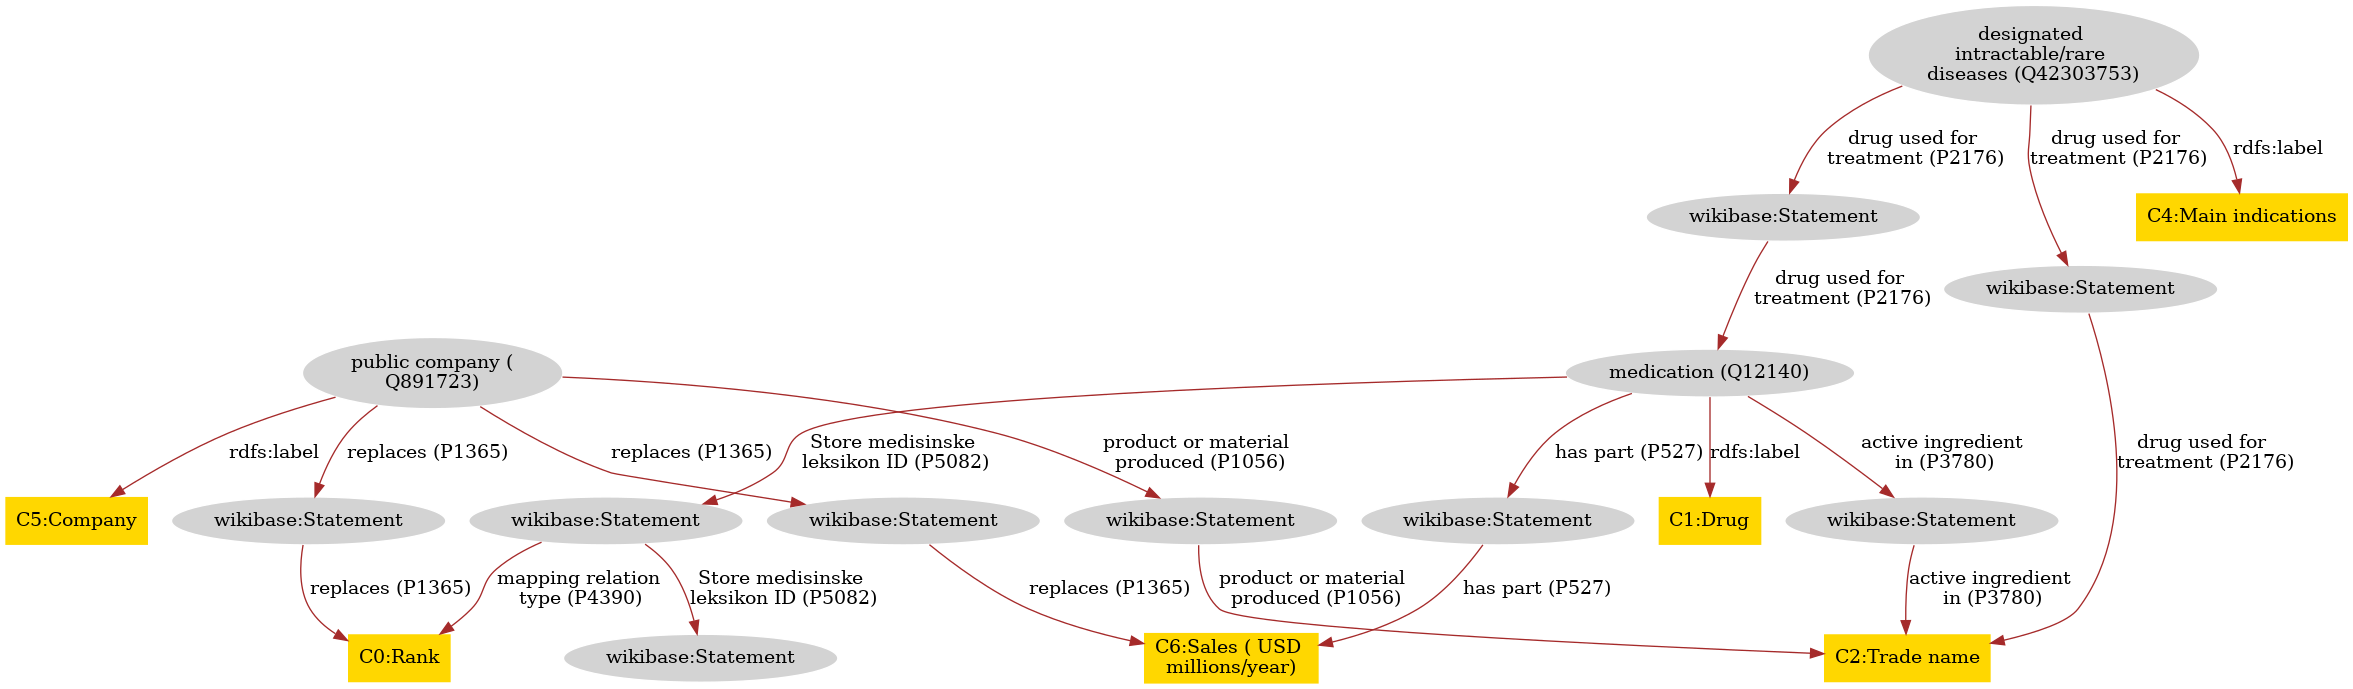

In [20]:
annotation.sm.draw()

In [9]:
table.table.df.to_csv("/workspace/sm-dev/grams/examples/novartis/tables/table_02.csv", index=False)

In [ ]:
outlinks = []
for ri, rlinks in enumerate(table.links):
    for ci, links in enumerate(rlinks):
        ents = {link.qnode_id for link in links if link.qnode_id is not None}
        if len(ents) > 0:
            outlinks.append([ri, ci] + list(sorted(ents)))
M.serialize_csv(outlinks, "/workspace/sm-dev/grams/examples/novartis/tables/table_02.links.tsv", delimiter='\t')

In [6]:
def display_df(df):
    display(df)

slider = SliderApp(BasicApp(display_df), 'set_data')
slider.render()

Output()

HTML(value='<div id="ed5e3ae9-f94b-45c2-ae26-df1a2db1f109"></div>')

Output()

SlowTunnelWidget(js_endpoint=(0, ''), py_endpoint=(0, ''), tunnel_id='aa49e35e-3182-4f67-912a-2f3696b381d2')

<IPython.core.display.Javascript object>

In [5]:
slider.set_data([
    {"description": "<br>" + " > ".join([r.header for r in table.context]), "args": [table.as_df()]}
    for table in tables
])

,0,1
0,,This article needs additional citations for ve...


**Annotate the selected table**

In [15]:
selected_table = 11

table = tables[selected_table]
table = table.as_relational_linked_table(table_id=f"{table.page_url}/{selected_table}")
annotation = grams.annotate(table)

IndexError: list index out of range

In [7]:
(cwd / f"ground-truth/{table.get_friendly_fs_id()}").mkdir(exist_ok=True)
M.serialize_json(table.to_json(), cwd / f"tables/{table.get_friendly_fs_id()}.json")
M.serialize_json(Session(table.id, False, "", table, [WikidataSemanticModelHelper.minify_sm(annotation.sm)]).to_json(), 
                 cwd / f"ground-truth/{table.get_friendly_fs_id()}/version.01.json") 

fname = table.get_friendly_fs_id()
description = f"<b>context</b>" + " > ".join([
    f"<b>[h{h.level}]</b> {h.header.strip()}" 
    for h in tables[selected_table].context
])
annotate_data = [(fname, description, table)]
assistant_data = [{"table": table, "sg": annotation.sg, "dg": annotation.dg}]

In [8]:
qnodes = grams.qnodes.cache_dict()
wdprops = grams.wdprops
wdclasses = grams.wdclasses.cache_dict()
es_host = 'http://mira.isi.edu:9200'

assistant = GRAMSAnnotatorAssistant(assistant_data, qnodes, wdprops)
annotator = Annotator(qnodes, wdclasses, wdprops, cwd / "ground-truth", es_host, username='', password='', dev=False, assistant=assistant)
annotator.render(True)

SlowTunnelWidget(js_endpoint=(0, ''), py_endpoint=(0, ''), tunnel_id='271081d6-8437-4615-8342-bda19355fbd8')

HTML(value='<div id="b68105e2-d631-4674-8515-901bc1c51e97"></div>')

<IPython.core.display.Javascript object>

In [9]:
annotator.annotate(annotate_data[0][0], annotate_data[0][2])